In [1]:
#|default_exp resnet

# ResNets

In [2]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 20.9 MB/s eta 0:00:00


In [3]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
get_model??

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)
File:      /notebooks/miniai/init.py
Type:      function


In [8]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [10]:
conv??

Signature:
conv(
    ni,
    nf,
    ks=3,
    stride=2,
    act=<class 'torch.nn.modules.activation.ReLU'>,
    norm=None,
    bias=None,
)
Docstring: <no docstring>
Source:   
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)
File:      /notebooks/miniai/init.py
Type:      function


## Going deeper

Before resnet lets go deeper in the architecture. Lets change the channels to take us up to 128. 

In [12]:
# 1 to 64 old
# 8 to 128
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d): 
    layers = [conv(1, 8, stride=1, act=act, norm=norm)] # add this one, stride of one , adding a last layer of 128
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [13]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.814,0.677,0,train
0.827,0.560,0,eval
0.886,0.329,1,train
0.877,0.346,1,eval
0.907,0.261,2,train
0.891,0.306,2,eval
0.926,0.211,3,train
0.916,0.240,3,eval
0.943,0.167,4,train
0.921,0.229,4,eval


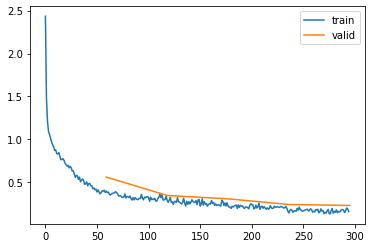

In [14]:
learn.fit(epochs)

## Skip Connections

it becomes a point that making neural nets deeper, stops working and becomes problematic.

The ResNet (*residual network*) was introduced in 2015 by Kaiming He et al in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). The key idea is using a *skip connection* to allow deeper networks to train successfully.

<img width="700" src="images/att_00042.png">

In [16]:
#|export
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks), # ni to nf
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks)) # out to out, nf to nf, activation not applied to 2nd conv

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None) # if not equal match nf , ponintwise conv
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # if th stride is two, average to match again the ni anf nf
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x))) # activation ( output + (input)) , used to handle different in/out shapes, activation to resiual is a good design choice according to JH

**Post-lesson update**: Piotr Czapla noticed that we forgot to include `norm=norm` in the call to `_conv_block` above, so the resnets in the lesson didn't have batchnorm in the resblocks! After fixing this, we discovered that initializing the `conv2` batchnorm weights to zero makes things worse in every model we tried, so we removed that. That init method was originally introduced to handle training extremely deep models (much deeper than we use here) -- it appears from this little test that it might be worse for less deep models.

In [17]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [49]:
input_tensor.shape

torch.Size([2, 3, 4, 4])

In [47]:
linear_output

tensor([-0.25, -0.19,  0.27,  0.08,  0.25,  0.04, -0.42,  0.94,  0.38, -0.17], grad_fn=<MvBackward0>)

In [50]:
conv_output.shape

torch.Size([2, 10, 4, 4])

In [37]:
reshaped_input

tensor([-0.67,  0.15,  0.91,  0.72,  0.26, -0.12,  0.21,  1.17, -0.50,  0.47, -0.88, -0.19, -0.07,  0.09,  0.22, -0.12,  2.03,  0.97, -2.08,
        -0.61, -1.74,  0.48,  1.67,  0.42,  0.62,  0.64,  1.36,  1.94,  0.53,  0.05,  1.15,  0.42, -1.10, -1.16,  1.56, -0.29, -1.20,  0.26,
        -0.09,  0.12, -1.64, -0.10,  0.61, -1.03, -1.72, -1.77, -0.49, -0.89, -0.34,  1.04, -0.19, -0.20, -0.36,  0.15, -0.55,  0.13,  0.47,
         0.73, -0.30,  1.46,  0.02, -2.47, -0.25, -1.38,  0.82,  0.13, -0.33, -1.27, -1.67,  0.57,  0.11,  0.75, -1.44,  0.65, -2.83,  0.70,
         0.68,  0.10, -1.27,  0.94, -1.26,  0.09,  0.87,  0.93,  1.55, -1.40, -0.51, -1.12,  0.19, -0.19,  0.25, -0.33,  1.92,  0.89, -1.55,
         0.85])

In [30]:
# Reshape linear output to match conv output
linear_output_reshaped = linear_output.reshape(batch_size, height, width, out_channels).permute(0, 3, 1, 2)

# Check if outputs are similar (they won't be exactly the same due to random initialization)
print("Conv output shape:", conv_output.shape)
print("Linear output shape:", linear_output_reshaped.shape)

Conv output shape: torch.Size([2, 5, 4, 4])
Linear output shape: torch.Size([2, 5, 4, 4])


In [18]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1, train=False)

ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])


In [26]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [27]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1228908


|Module|Input|Output|Num params|
|--|--|--|--|
|ResBlock|(2048, 1, 28, 28)|(2048, 8, 28, 28)|712|
|ResBlock|(2048, 8, 28, 28)|(2048, 16, 14, 14)|3696|
|ResBlock|(2048, 16, 14, 14)|(2048, 32, 7, 7)|14560|
|ResBlock|(2048, 32, 7, 7)|(2048, 64, 4, 4)|57792|
|ResBlock|(2048, 64, 4, 4)|(2048, 128, 2, 2)|230272|
|ResBlock|(2048, 128, 2, 2)|(2048, 256, 1, 1)|919296|
|Flatten|(2048, 256, 1, 1)|(2048, 256)|0|
|Linear|(2048, 256)|(2048, 10)|2560|
|BatchNorm1d|(2048, 10)|(2048, 10)|20|


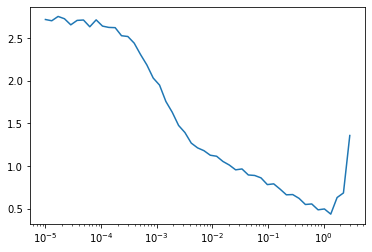

In [28]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [24]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.815,0.707,0,train
0.861,0.471,0,eval
0.893,0.353,1,train
0.875,0.368,1,eval
0.916,0.255,2,train
0.902,0.283,2,eval
0.935,0.195,3,train
0.915,0.244,3,eval
0.953,0.148,4,train
0.929,0.210,4,eval


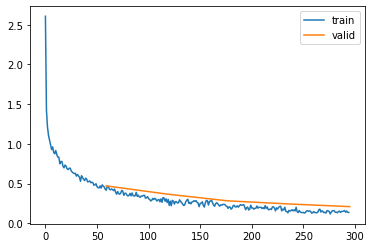

In [25]:
learn.fit(epochs)

In [29]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [30]:
' '.join(timm.list_models('*resnet*'))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight ens_adv_inception_resnet_v2 gcresnet33ts gcresnet50t gluon_resnet18_v1b gluon_resnet34_v1b gluon_resnet50_v1b gluon_resnet50_v1c gluon_resnet50_v1d gluon_resnet50_v1s gluon_resnet101_v1b gluon_resnet101_v1c gluon_resnet101_v1d gluon_resnet101_v1s gluon_resnet152_v1b gluon_resnet152_v1c gluon_resnet152_v1d gluon_resnet152_v1s inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_gn resnet50d resnet50t resnet51q resnet61q resnet101 resnet101d resnet152 resne

```
resnet18:  block=BasicBlock, layers=[2, 2, 2, 2]
resnet18d: block=BasicBlock, layers=[2, 2, 2, 2], stem_width=32, stem_type='deep', avg_down=True
resnet10t: block=BasicBlock, layers=[1, 1, 1, 1], stem_width=32, stem_type='deep_tiered', avg_down=True
```

In [31]:
model = timm.create_model('resnet18d', in_chans=1, num_classes=10)
# model = ResNet(in_chans=1, block=BasicBlock, layers=[2,2,2,2], stem_width=32, avg_down=True)

In [33]:
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.784,0.630,0,train
0.802,0.720,0,eval
0.876,0.331,1,train
0.854,0.396,1,eval
0.906,0.252,2,train
0.886,0.337,2,eval
0.925,0.198,3,train
0.915,0.239,3,eval
0.946,0.148,4,train
0.922,0.219,4,eval


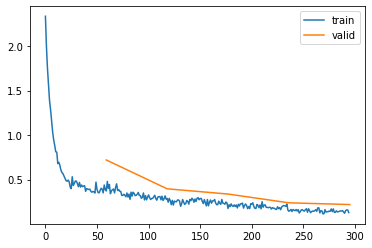

In [34]:
learn.fit(epochs)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()